### This notebook will be using past volatility and past returns for the S&P500 in order to try to build a multiple linear regression model in order to predict the S&P500 returns in the next 30 days:

### Importing necessary modules:

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as dt

### Importing and structuring S&P500 data:

##### We will be using 30, 63 and 126 days for calculating past returns and past volatility

In [34]:
data = dt.DataReader("^GSPC",data_source="yahoo",start=1970)

# Last 30 days volatility: 
data["30 Vol"] = data["Adj Close"].pct_change().rolling(30).std()

# Last 63 days volatility: 
data["63 Vol"] = data["Adj Close"].pct_change().rolling(63).std()

# Last 126 days volatility: 
data["126 Vol"] = data["Adj Close"].pct_change().rolling(126).std()

# Last 30 days return:
data["30 Returns"]=data["Adj Close"].pct_change(30)

# Last 63 days return:
data["63 Returns"]=data["Adj Close"].pct_change(63)

# Last 126 days return:
data["126 Returns"]=data["Adj Close"].pct_change(126)

# Next 30 days return:
data["Next 30 Returns"]=data["Adj Close"].pct_change(-30)

# Dropping the initial columns from the data set: 
data.drop(["High","Open","Close","Adj Close","Volume","Low"],axis=1,inplace=True)

# Dropping nans:
data.dropna(inplace=True)

# Adding numeric index:
data.reset_index(inplace=True)

# Dropping dates from the data set:
data.drop(["Date"],axis=1,inplace=True)

data

,30 Vol,63 Vol,126 Vol,30 Returns,63 Returns,126 Returns,Next 30 Returns
0,0.016405,0.013776,0.010967,-0.007889,-0.184025,-0.215699,-0.024345
1,0.016035,0.013771,0.010951,0.010532,-0.178459,-0.219773,-0.030061
2,0.016301,0.013863,0.011010,-0.006505,-0.189110,-0.226675,-0.047126
3,0.015524,0.013869,0.011022,0.013950,-0.195050,-0.231027,-0.065223
4,0.015893,0.014310,0.011277,0.053543,-0.175421,-0.212344,-0.051455
...,...,...,...,...,...,...,...
12633,0.010898,0.013760,0.028995,0.050004,0.155583,0.014137,-0.033226
12634,0.010852,0.013771,0.028995,0.063553,0.158956,0.014063,-0.031339
12635,0.010824,0.013746,0.028967,0.060506,0.152721,0.002705,-0.023329
12636,0.010847,0.013703,0.028956,0.062747,0.168286,-0.002075,-0.008710


### Building train and test sets:

In [35]:
# Random sample with 90% of the indexes in the data set:
idx = np.random.randint(1,len(data),int(0.9*len(data)))

# Using 90% of the data to test the model and other 10% to test it: 
train_set = data.loc[idx]
test_set = data.drop(idx)

### Building the linear regression model:

In [36]:
# Using sklearn to build the model:
from sklearn.linear_model import LinearRegression
x_train = train_set.drop(["Next 30 Returns"],axis=1)
y_train = train_set[["Next 30 Returns"]]
x_test = test_set.drop(["Next 30 Returns"],axis=1)
y_test = test_set[["Next 30 Returns"]]

# Multiple linear regression model:
model = LinearRegression()
model.fit(x_train,y_train);

### Running the model in the test set:

In [37]:
results_predicted= model.predict(x_test)

### Plotting the results: 

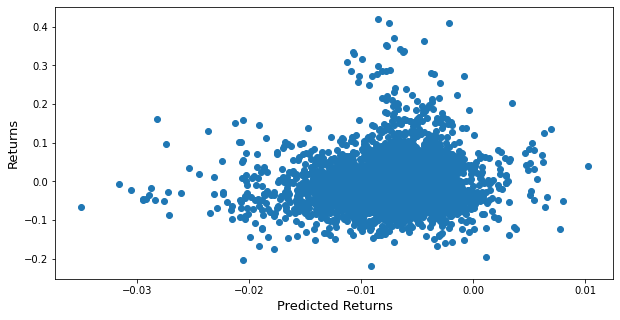

In [38]:
plt.figure(figsize=(10,5))
plt.scatter(results_predicted,y_test)
plt.xlabel("Predicted Returns",fontsize=13)
plt.ylabel("Returns",fontsize=13);

### Percentage of the time the model got the signal right:

In [39]:
signal = (np.where(results_predicted>0,1,0))
signal = [i[0] for i in signal]
actuall = (test_set["Next 30 Returns"]>0).astype(int)
print("% of the time the model got the signal right (positive or negative) = ",(actuall==signal).mean())

% of the time the model got the signal right (positive or negative) =  0.6190752563358484
